<h1 id="Kaggle-Digit-Recognizer ">Kaggle Digit Recognizer&nbsp;</h1>

<p>MNIST image classification with CNN model and&nbsp;TensorFlow&nbsp;Estimator</p>

<p>step&nbsp;highlights:</p>

<ol>
	<li>image input from local data csv</li>
	<li>image reshape&nbsp;to [-1, HEIGHT, WIDTH,&nbsp; 1],&nbsp;serving_input_fn need to expand dim in feature</li>
	<li>label converted one_hot, use softmax cross entrocpy for loss&nbsp;</li>
	<li>build model and cutom estimator, NOT transform from keras model, for more control of parameters</li>
	<li>decay learning rate</li>
	<li>implement data aumentation each epoch and evaluate</li>
	<li>export model</li>
	<li>launch tensorboard</li>
	<li>predict&nbsp;and ouput</li>
</ol>

<p>&nbsp;</p>


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

#import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import TensorBoard

tf.logging.set_verbosity(tf.logging.INFO)

1.13.1


### Exploring the data



In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.label.count()

42000

In [5]:
train_images = train.drop(labels = ["label"],axis = 1)
train_labels = train["label"].astype('int32')

train_images = train_images.to_numpy().astype('float32')/255.0
test_images = test.to_numpy().astype('float32')/255.0

In [6]:
train_labels.dtype

dtype('int32')

In [7]:
HEIGHT = 28
WIDTH = 28
NCLASSES = 10

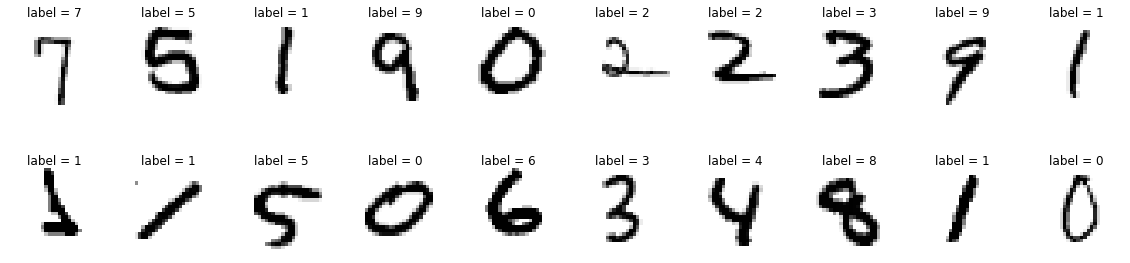

In [8]:
i = 50
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(train_images[IMGNO].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.title("label = %d" % train_labels[IMGNO],y=0.9)
    plt.axis('off')

In [9]:
train_labels.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [10]:
train_images = train_images.reshape(-1,HEIGHT,WIDTH,1)
test_images = test_images.reshape(-1,HEIGHT,WIDTH,1)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = NCLASSES)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, train_labels, test_size = 0.1)

len(Y_train)

37800

## Data augmentation

In [12]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

datagen.fit(X_train)

## Build a CNN model and classifier


In [13]:
def cnn_model(features, labels, mode, params):

    X = features['image']

    c1 = tf.layers.conv2d(inputs = X, filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation = tf.nn.relu)  # shape = (batch_size, HEIGHT, WIDTH, nfil1)

    p1 = tf.layers.max_pooling2d(inputs=c1, pool_size = 2, strides = 2)                                              # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil1)
    
    c2 = tf.layers.conv2d(inputs = p1, filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = tf.nn.relu)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)
    
    p2 = tf.layers.max_pooling2d(inputs=c2, pool_size = 2, strides = 2)                                                       # shape = (batch_size, HEIGHT // 4, WIDTH // 4, nfil2)

    c3 = tf.layers.conv2d(inputs = p2, filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = tf.nn.relu)    # shape = (batch_size, HEIGHT // 2, WIDTH // 2, nfil2)

    p3 = tf.layers.max_pooling2d(inputs=c3, pool_size = 2, strides = 2)     

    p3flat =  tf.reshape(tensor = p3, shape= [-1, p3.shape[1] * p3.shape[2] * p3.shape[3]])                                                                  # shape = (batch_size, HEIGHT // 4 * WIDTH // 4 * nfil2)

    h3 = tf.layers.dense(inputs = p3flat, units = 64, activation = tf.nn.relu)
    
    h3d = tf.layers.dropout(inputs = h3, rate = 0.25, training = (mode == tf.estimator.ModeKeys.TRAIN))    
    
    ylogits = tf.layers.dense(inputs = h3d, units = NCLASSES, activation = None)
  

    probabilities = tf.nn.softmax(logits = ylogits)
    
    class_ids = tf.cast(x = tf.argmax(input = probabilities, axis = 1), dtype = tf.uint8)

    if mode == tf.estimator.ModeKeys.TRAIN :
        loss = tf.reduce_mean(input_tensor = tf.nn.softmax_cross_entropy_with_logits(logits = ylogits, labels = labels))
               
        global_step = tf.train.get_global_step()

        decay_steps = params["decay_steps"]
        
        learning_rate = params["learning_rate"]
            
        def _learning_rate_decay_fn(learning_rate, global_step):
              return tf.train.exponential_decay(
                  learning_rate,
                  global_step,
                  decay_steps=decay_steps,
                  decay_rate=0.95,
                  staircase=True)
        
        train_op = tf.contrib.layers.optimize_loss(
                loss = loss, 
                global_step = global_step,
                learning_rate =learning_rate, 
                learning_rate_decay_fn=_learning_rate_decay_fn,
                optimizer = "Adam")
        eval_metric_ops = None
    
    if mode == tf.estimator.ModeKeys.EVAL:
        loss = tf.reduce_mean(input_tensor = tf.nn.softmax_cross_entropy_with_logits(logits = ylogits, labels = labels))
        train_op = None
        eval_metric_ops =  {"accuracy": tf.metrics.accuracy(labels = tf.argmax(input = labels, axis = 1), predictions = class_ids)}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        loss = None
        train_op = None
        eval_metric_ops = None

    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = {"probabilities": probabilities, "class_ids": class_ids},
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = {"predictions": tf.estimator.export.PredictOutput({"probabilities": probabilities, "class_ids": class_ids})}
    )





## Input functions for training, evaluation, and predicition.

In [19]:
def serving_input_fn():

    feature_placeholders = {"image": tf.placeholder(dtype = tf.float32, shape = [None, HEIGHT, WIDTH])}

    features = {"image": tf.expand_dims(input = feature_placeholders["image"], axis = -1)} 
    return tf.estimator.export.ServingInputReceiver(features =  features, receiver_tensors =  feature_placeholders)

## Train locally


In [15]:
np.shape(X_train)

(37800, 28, 28, 1)

In [22]:
# clear cache otherwise logging to tfevent file may fail due to removal (shutil.rmtree) and recreate the output file. 
tf.summary.FileWriterCache.clear()

OUTDIR = "mnist\learned_v03"
shutil.rmtree(path = OUTDIR, ignore_errors = True) # start fresh each time

hparams = {"epochs": 30, 
           "batch_size": 100, 
           "decay_steps":len(Y_train)//100, #378
           "learning_rate": 0.001, 
           "batch_norm":0 }

estimator = tf.estimator.Estimator(
        model_fn = cnn_model,
        model_dir =  OUTDIR,
        params = hparams)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image': X_val},
    y = Y_val,
    batch_size = hparams['batch_size'],
    num_epochs = 1,
    shuffle = False,
    queue_capacity = 5000 #TODO   
    )
    

for ep in range(hparams['epochs']):
        
    (X_train_da, Y_train_da)  = datagen.flow(X_train, Y_train, batch_size = len(Y_train)).next()
        
              
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x = {'image':X_train_da},
            y = Y_train_da,
            batch_size = hparams['batch_size'],
            num_epochs = 1,
            shuffle = True,
            queue_capacity = 5000
            )
        
    estimator.train(input_fn=train_input_fn)
    
    eval_results = estimator.evaluate(input_fn=eval_input_fn)
        
    print("epoch {0:02d}: {1} \n".format(ep, eval_results)) 
    
#exporter = tf.estimator.LatestExporter(name = "exporter", serving_input_receiver_fn = serving_input_fn)

estimator.export_saved_model(OUTDIR+"\\export",  serving_input_fn) 
    

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'mnist\\learned_v03', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000025ABCC49C18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Gr

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21T18:54:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-1890
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-18:54:21
INFO:tensorflow:Saving dict for global step 1890: accuracy = 0.99, global_step = 1890, loss = 0.02973949
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1890: mnist\learned_v03\model.ckpt-1890
epoch 04: {'accuracy': 0.99, 'loss': 0.02973949, 'global_step': 1890} 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-1890
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1890 into mn

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3780: mnist\learned_v03\model.ckpt-3780
epoch 09: {'accuracy': 0.9911905, 'loss': 0.024168752, 'global_step': 3780} 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-3780
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3780 into mnist\learned_v03\model.ckpt.
INFO:tensorflow:loss = 0.009181328, step = 3781
INFO:tensorflow:global_step/sec: 6.92054
INFO:tensorflow:loss = 0.062325295, step = 3881 (14.450 sec)
INFO:tensorflow:global_step/sec: 6.89026
INFO:tensorflow:loss = 0.034911353, step = 3981 (14.513 sec)
INFO:tensorflow:global_step/sec: 6.99575
INFO:tensorflow:loss = 0.12877712, step = 4081 (14.404 sec)
INFO:tensorflow:Saving checkpoints for 4158 into mnist\learned_v03\model

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5670 into mnist\learned_v03\model.ckpt.
INFO:tensorflow:loss = 0.148832, step = 5671
INFO:tensorflow:global_step/sec: 6.81627
INFO:tensorflow:loss = 0.0442786, step = 5771 (14.675 sec)
INFO:tensorflow:global_step/sec: 6.83233
INFO:tensorflow:loss = 0.044763822, step = 5871 (14.632 sec)
INFO:tensorflow:global_step/sec: 6.97131
INFO:tensorflow:loss = 0.026209168, step = 5971 (14.345 sec)
INFO:tensorflow:Saving checkpoints for 6048 into mnist\learned_v03\model.ckpt.
INFO:tensorflow:Loss for final step: 0.06316693.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21T19:07:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-6048
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-19:07:36
INFO:tensorf

INFO:tensorflow:Saving checkpoints for 7938 into mnist\learned_v03\model.ckpt.
INFO:tensorflow:Loss for final step: 0.04250818.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21T19:13:35Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-7938
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-19:13:38
INFO:tensorflow:Saving dict for global step 7938: accuracy = 0.99523807, global_step = 7938, loss = 0.015752785
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7938: mnist\learned_v03\model.ckpt-7938
epoch 20: {'accuracy': 0.99523807, 'loss': 0.015752785, 'global_step': 7938} 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramete

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-19:19:38
INFO:tensorflow:Saving dict for global step 9828: accuracy = 0.9945238, global_step = 9828, loss = 0.019236341
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 9828: mnist\learned_v03\model.ckpt-9828
epoch 25: {'accuracy': 0.9945238, 'loss': 0.019236341, 'global_step': 9828} 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-9828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9828 into mnist\learned_v03\model.ckpt.
INFO:tensorflow:loss = 0.0038779834, step = 9829
INFO:tensorflow:global_step/sec: 6.85494
INFO:tensorflow:loss = 0.0140932845, step = 9929 (14.588 sec)
INFO:tensorflow:global_step/sec: 6.93489
INFO:tensorflow:lo

b'mnist\\learned_v03\\export\\1566415462'

In [ ]:
# in terminal tensorboard --logdir C:\Users\...\mnist\learned_v03 --host=127.0.0.1

<h2>Graph</h2>


<img src="images/graph_run_estimator-v3.png">


<h2 id="scalars">Scalars</h2>

<p><img src="images/tensorboard-estimator-v3.png" /></p>


In [23]:
print(eval_results)

{'accuracy': 0.9947619, 'loss': 0.019365253, 'global_step': 11340}


## Prediction

In [24]:
len(test_images)

28000

In [25]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'image':test_images},
    y = None,
    batch_size = 2000,
    num_epochs = 1,
    shuffle = False,
      )


pred_gen = estimator.predict(input_fn=pred_input_fn)

pred = np.array(list(p['class_ids'] for p in pred_gen))
#pred = np.argmax(pred,axis = 1)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mnist\learned_v03\model.ckpt-11340
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [26]:
pred[:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3], dtype=uint8)

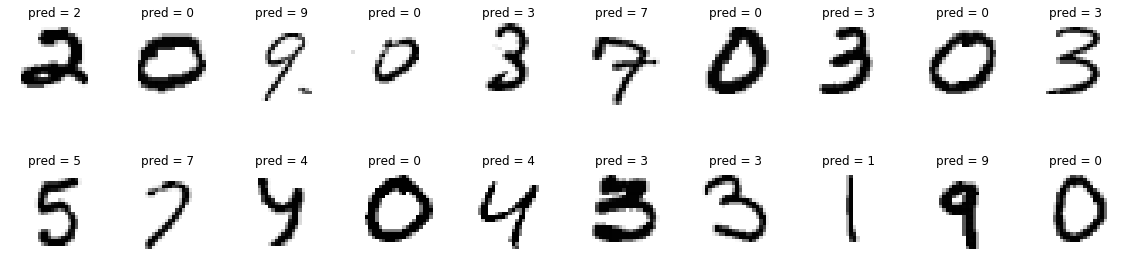

In [27]:
i=0
plt.figure(figsize=(20,5))
for IMGNO in range(i,i+20):  
    plt.subplot(2, 10, IMGNO-i+1)
    plt.imshow(test_images[IMGNO].reshape((28,28)),cmap=plt.cm.binary)
    plt.title("pred = %d" % pred[IMGNO],y=0.9)
    plt.axis('off')
#plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [31]:
output = pd.DataFrame({ 'ImageId' : np.arange(len(pred))+1, 'Label': pred })
output.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [30]:
#output.to_csv('data/sub_digit_cnn_estimator_v03_da_30ep.csv', index = False)

<h2>Results comparison</h2>

<table align="left" border="2" cellpadding="1" cellspacing="1" style="width: 500px">
	<thead>
		<tr>
			<th scope="col">kaggle score</th>
			<th scope="col">rank</th>
			<th scope="col">data augmentation</th>
			<th scope="col">model build</th>
			<th scope="col">epochs</th>
		</tr>
	</thead>
	<tbody>
		<tr>
			<td>0.99057</td>
			<td>&nbsp;</td>
			<td>No</td>
			<td>keras</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.00257</td>
			<td>910</td>
			<td>Yes</td>
			<td>keras</td>
			<td>20</td>
		</tr>
		<tr>
			<td>0.99400</td>
			<td>&nbsp;</td>
			<td>Yes</td>
			<td>estimator</td>
			<td>30</td>
		</tr>
		<tr>
			<td>0.99457</td>
			<td>655</td>
			<td>Yes</td>
			<td>keras</td>
			<td>30</td>
		</tr>
	</tbody>
</table>


<h2 id="notes">Notes</h2>

<p>when building keras model use&nbsp;<em>model = tf.keras.Model(inputs=X, outputs=output)</em>. Do NOT use <em>keras.Model</em> which gives the follow error&nbsp;</p>

<pre>
ValueError: (&#39;Expected `model` argument to be a `Model` instance, got &#39;, &lt;keras.engine.training.Model object at 0x000002C3A950F2B0&gt;)</pre>

<p>actually, for consistency and avoiding incompatible issues, use <em>tf.keras</em> all the way.</p>

<p>&nbsp;</p>

<p># clear cache before training otherwise logging to tfevent file may fail and tansorboard shows nothing due to removal (shutil.rmtree) and recreate the output file.<br />
tf.summary.FileWriterCache.clear()</p>

<p>&nbsp;</p>


<h2 id="Next-steps">Next steps</h2>

<ol>
	<li>create GCP training files</li>
	<li>ensemble method</li>
	<li>TF2</li>
</ol>

<h2 id="Credits">Credits</h2>

<p><a href="https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive/08_image">https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/deepdive/08_image</a></p>

<p><a href="https://www.tensorflow.org/guide/estimators" target="_blank">https://www.tensorflow.org/guide/estimators</a></p>

<p>&nbsp;</p>

<p>&nbsp;</p>
